In [28]:
import numpy as np
import os 
from skimage import io, measure
from PIL import Image
import napari
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from tqdm.notebook import tqdm

from cell_paint_seg.utils import get_id_to_path, \
                                row_col_field_from_id, \
                                check_valid_labels, \
                                combine_soma_nucleus_labels, \
                                match_small_to_big, \
                                combine_small_big_labels_instance, \
                                threat_score
from cell_paint_seg.image_io import read_ims, read_seg

In [2]:
path_images = "./data/tifs"
path_seg_final = "./data/seg_final"
channels = ["Brightfield", "ER", "AGP", "Mito", "DNA", "RNA"]
res = 5.98e-7

path_twochannel = "./data/twochannel"

def name_from_id(id):
    return id[:9]
id_to_paths = get_id_to_path(path_images, name_from_id, tag=".tiff")

# Image sampling

There are two plates, and two sets of wells for each of two control cell lines. I will identify a single DMSO well for each control line, on each plate

In [ ]:
for plate in range(2):
    for line in range(2):
        row = np.random.randint(0,16) + 1
        row = str(row).zfill(2)

        field = np.random.randint(0, 9) + 1
        field = str(field).zfill(2)
        print(f"For plate {plate}, control line {line}, we will annotate r{row}c?f{field}")


# Image processing

In [4]:
# if the folder path_twochannel does not exist, create it
if not os.path.exists(path_twochannel):
    os.makedirs(path_twochannel)

In [ ]:
for id, paths in id_to_paths.items():
    ims = read_ims(paths)

    im_2channel = np.stack([ims[channels.index(c)] for c in ["RNA", "DNA"]], axis=-1)
                           
    # save the two channel image
    path = os.path.join(path_twochannel, f"{id}.tiff")
    io.imsave(path, im_2channel)


In [11]:
id = "r07c01f01"

ims = read_ims(id_to_paths[id])

viewer = napari.Viewer()
for im, channel in zip(ims, channels):
    viewer.add_image(im, name=channel)

# Harmonize nuclei, somas, and cells

In [10]:
path_nuclei = "./data/twochannel/v2/nuclei"
path_somas = "./data/twochannel/v2/somas"
path_cells = "./data/twochannel/v2/cells"

id_to_paths_im = get_id_to_path(path_images, name_from_id, tag=".tiff")
id_to_paths_nuclei = get_id_to_path(path_nuclei, name_from_id, tag=".npy")
id_to_paths_somas = get_id_to_path(path_somas, name_from_id, tag=".npy")
id_to_paths_cells = get_id_to_path(path_cells, name_from_id, tag=".npy")

In [ ]:
counter = 0

for id, paths in id_to_paths_nuclei.items():
    seg_nuc = read_seg(paths)
    seg_soma = read_seg(id_to_paths_somas[id])
    seg_cell = read_seg(id_to_paths_cells[id])

    ims = read_ims(id_to_paths[id])

    print(f"{len(np.unique(seg_nuc))} unique nuclei labels and {len(np.unique(seg_soma))} unique soma labels")
    matches, unmatched_nuc, unmatched_soma = match_small_to_big(seg_nuc, seg_soma)
    if len(unmatched_nuc) > 0 or len(unmatched_soma) > 0:  
        print(f"{len(unmatched_nuc)} unmatched nuclei and {len(unmatched_soma)} unmatched somas")
        nuc_unmatched = np.zeros_like(seg_nuc)
        soma_unmatched = np.zeros_like(seg_soma)
        for nuc_id in unmatched_nuc:
            nuc_unmatched[seg_nuc == nuc_id] = nuc_id
        for soma_id in unmatched_soma:
            soma_unmatched[seg_soma == soma_id] = soma_id

        viewer = napari.Viewer()
        for im, channel in zip(ims, channels):
            viewer.add_image(im, name=f"{id} - {channel}")
        viewer.add_labels(nuc_unmatched, name="unmatched nuclei")
        viewer.add_labels(soma_unmatched, name="unmatched somas")
        break

    print(f"{len(np.unique(seg_soma))} unique soma labels and {len(np.unique(seg_cell))} unique cell labels")
    matches, unmatched_soma, unmatched_cell = match_small_to_big(seg_soma, seg_cell)
    if len(unmatched_soma) > 0 or len(unmatched_cell) > 0:
        print(f"{len(unmatched_soma)} unmatched somas and {len(unmatched_cell)} unmatched cells")  
        soma_unmatched = np.zeros_like(seg_soma)
        cell_unmatched = np.zeros_like(seg_cell)
        for soma_id in unmatched_soma:
            soma_unmatched[seg_nuc == soma_id] = soma_id
        for cell_id in unmatched_cell:
            cell_unmatched[seg_cell == cell_id] = cell_id

        viewer = napari.Viewer()
        for im, channel in zip(ims, channels):
            viewer.add_image(im, name=f"{id} - {channel}")
        viewer.add_labels(soma_unmatched, name="unmatched somas")
        viewer.add_labels(cell_unmatched, name="unmatched cells")
        break

    seg_soma_filtered = combine_small_big_labels_instance(seg_nuc, seg_soma)
    seg_cell_filtered = combine_small_big_labels_instance(seg_soma_filtered, seg_cell)
    
    check_valid_labels(seg_nuc, seg_soma_filtered, seg_cell_filtered)

    io.imsave(Path(path_seg_final) / f"{id}_nuclei.tif", seg_nuc)
    io.imsave(Path(path_seg_final) / f"{id}_somas.tif", seg_soma_filtered)
    io.imsave(Path(path_seg_final) / f"{id}_cells.tif", seg_cell_filtered)

    counter += len(np.unique(seg_cell_filtered))-1
    

print(f"{counter} total cells")




# View image

In [ ]:
id_to_paths_nuc = get_id_to_path(path_seg_final, name_from_id, tag="_nuclei.tif")
id_to_paths_som = get_id_to_path(path_seg_final, name_from_id, tag="_somas.tif")
id_to_paths_cel = get_id_to_path(path_seg_final, name_from_id, tag="_cells.tif")

for id, paths in id_to_paths_nuc.items():
    ims = read_ims(id_to_paths[id])
    seg_nuc = read_seg(id_to_paths_nuc[id])
    seg_som = read_seg(id_to_paths_som[id])
    seg_cel = read_seg(id_to_paths_cel[id])

    break

viewer = napari.Viewer()
viewer.add_image(ims[-1], name="image")
viewer.add_labels(seg_nuc, name="nuclei")
viewer.add_labels(seg_som, name="somas")
viewer.add_labels(seg_cel, name="cells")



# Make unique ids

In [ ]:
path_redundant = "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/384_control/data/predictions/cyto2_omni/raw"
# read every png in path_redundant
for path in Path(path_redundant).rglob("*.png"):
    im = Image.open(path)
    im = np.array(im)

    im_new = np.zeros_like(im)
    counter = 1
    for val in np.unique(im[im != 0]):
        labels = measure.label(im == val)
        for lab in np.unique(labels[labels != 0]):
            im_new[labels == lab] = counter
            counter += 1

    path = Path(path)
    path_new = path.parents[1] / "instance" / f"{path.stem}.tif"
    print(path)
    print(path_new)

    io.imsave(path_new, im_new)


# Evaluate algorithm

In [ ]:
path_gt = "./data/seg_final/"
path_pred = "./data/predictions/cyto3"

tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}

data_threat = []
data_iou = []
data_comp = []
data_method = []


for method in ["cyto3", "cyto2_omni"]:
    path_pred = f"./data/predictions/{method}"
    for compartment in tqdm(["nuc", "soma", "cell"], desc="compartments..."):
        id_to_paths_gt = get_id_to_path(path_gt, name_from_id, tag=f"_{compartment}")
        id_to_paths_pred = get_id_to_path(path_pred, name_from_id, tag=f"_{compartment}")


        for id, path in tqdm(id_to_paths_gt.items(), leave=False, desc="ids..."):
            seg_gt = read_seg(path)
            seg_pred = read_seg(id_to_paths_pred[id])

            for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
                data_iou.append(iou_thresh)
                data_threat.append(threat_score(seg_gt, seg_pred, iou_thresh))
                data_comp.append(tag_to_name[compartment])
                data_method.append(method)

df = pd.DataFrame({"IoU Threshold": data_iou, "Threat Score": data_threat, "Method": data_method, "Compartment": data_comp})


In [36]:
for method in ["cyto2_omni"]:
    path_pred = f"./data/predictions/{method}"
    for compartment in tqdm(["nuc", "soma", "cell"], desc="compartments..."):
        id_to_paths_gt = get_id_to_path(path_gt, name_from_id, tag=f"_{compartment}")
        id_to_paths_pred = get_id_to_path(path_pred, name_from_id, tag=f"_{compartment}")


        for id, path in tqdm(id_to_paths_gt.items(), leave=False, desc="ids..."):
            seg_gt = read_seg(path)
            seg_pred = read_seg(id_to_paths_pred[id])

            for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
                data_iou.append(iou_thresh)
                data_threat.append(threat_score(seg_gt, seg_pred, iou_thresh))
                data_comp.append(tag_to_name[compartment])
                data_method.append(method)

df = pd.DataFrame({"IoU Threshold": data_iou, "Threat Score": data_threat, "Method": data_method, "Compartment": data_comp})

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

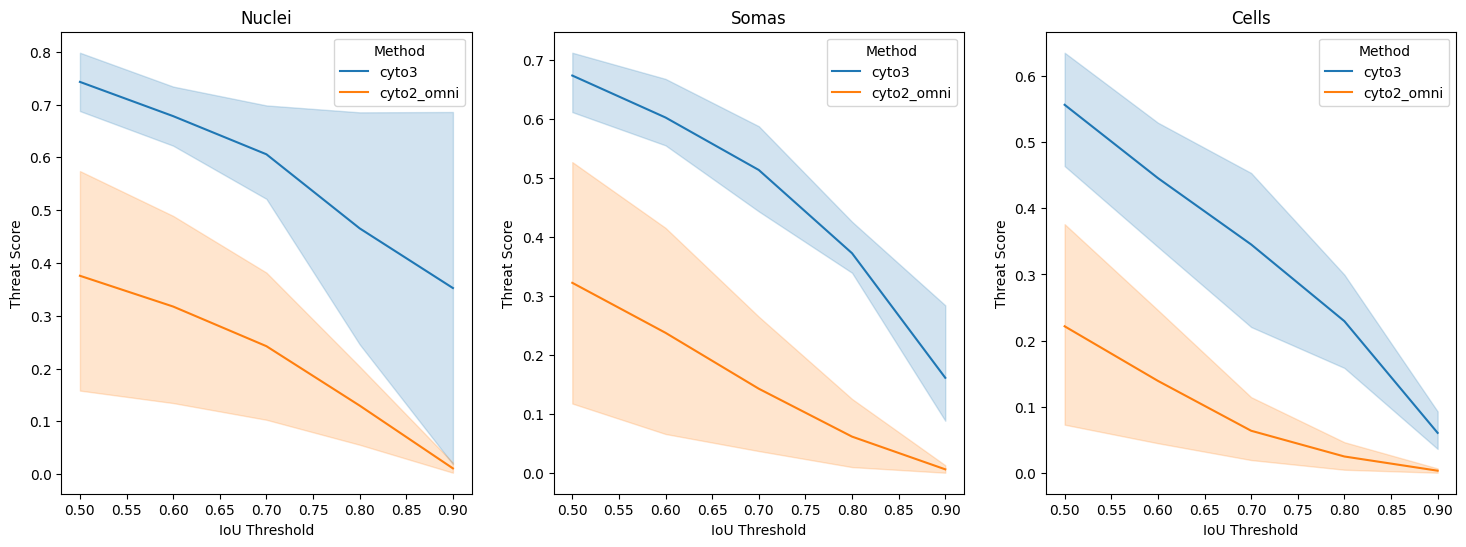

In [38]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

for compartment, ax in zip(["Nuclei", "Somas", "Cells"], axs):
    sns.lineplot(data=df[df["Compartment"] == compartment], x="IoU Threshold", y="Threat Score", hue="Method", ax=ax)
    ax.set_title(compartment)

plt.savefig("./data/figures/results/threat.svg")